## Visualizing movies spanning across different time periods & languages in the form of clusters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data=pd.read_csv(r'../Desktop/DATASETS_ALL/Movies.csv',encoding='utf-8',low_memory=False)
data.head()

Unnamed: 0     id  adult                        title original_language  \
0           0    278  False     The Shawshank Redemption                en   
1           1  19404  False  Dilwale Dulhania Le Jayenge                hi   
2           2    238  False                The Godfather                en   
3           3    424  False             Schindler's List                en   
4           4    240  False        The Godfather Part II                en   

                                            overview  \
0  Framed in the 1940s for the double murder of h...   
1  Raj is a rich, carefree, happy-go-lucky second...   
2  Spanning the years 1945 to 1955, a chronicle o...   
3  The true story of how businessman Oskar Schind...   
4  In the continuing saga of the Corleone crime f...   

                       title.1  popularity release_date  vote_average  \
0     The Shawshank Redemption      86.715   1994-09-23           8.7   
1  Dilwale Dulhania Le Jayenge      54.110   1995-10-19           8.7   
2                The Godfather     121.661   1972-03-14           8.7   
3             Schindler's List      55.646   1993-12-15           8.6   
4        The Godfather Part II      62.479   1974-12-20           8.6   

   vote_count  
0       21988  
1        3769  
2       16371  
3       13038  
4        9868

In [3]:
datacopy=data.copy()
datacopy2=data.copy()
#creating a checkpoint

In [4]:
saved_overview_text=[i for i in data['overview']]

len(saved_overview_text)

9980

In [5]:
saved_overview_text[9000]

'Verena is a nurse who arrives at an old mansion in Italy to help a young boy who has fallen silent since the sudden passing of his mother.'

## For the first viz, I would be using 

In [6]:
!pip install langcodes

In [7]:
!pip install language_data

In [6]:
lang_codes=data['original_language'].unique()

from langcodes import *


def map_code2lang(x):
    for i in lang_codes:
        if i==x:
            language=Language.make(language=i).display_name()
        
    return language.lower()

data['original_language']=data['original_language'].apply(lambda x: map_code2lang(x))

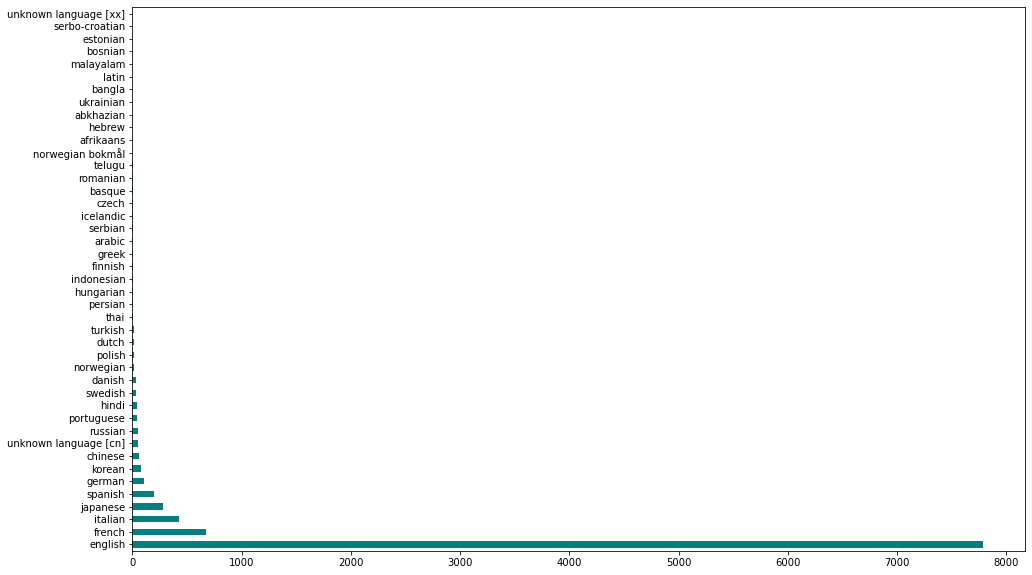

In [7]:
data['original_language'].value_counts().plot(kind='barh',figsize=(16,10),color='teal');


In [8]:
data['original_language'].value_counts().T

english                  7784
french                    675
italian                   427
japanese                  280
spanish                   196
german                    103
korean                     77
chinese                    57
unknown language [cn]      56
russian                    48
portuguese                 43
hindi                      42
swedish                    36
danish                     31
norwegian                  18
polish                     16
dutch                      13
turkish                    11
thai                       10
persian                     7
hungarian                   6
indonesian                  6
finnish                     4
greek                       4
arabic                      3
serbian                     3
icelandic                   3
czech                       3
basque                      2
romanian                    2
telugu                      2
norwegian bokmål            1
afrikaans                   1
hebrew    

#### So, the first problem here entials the huge class imbalance that lies in the dataset. To tackle that, I am basing our judgements on the 'top 50' (in terms of 'vote_score') from the highest crossing languages in the dataset (like english, french,hindi, italian etc) which have round >100 movies each. Although common middle-eastern languages like persian and arabic each have only 7 and 3 (respectively) representatives in the dataset, I am clubbing them together to have some significant reprentation from the middle-east film world. Others with <30 representations in the dataset, will unfortunately have to be skipped to remove bias.

### Categorizing the release years of movies into different timeframe periods

In [9]:
data['release_date']=pd.to_datetime(data['release_date'],format='%Y-%m-%d')

In [10]:
stored_year_labels=[]
for i in pd.DatetimeIndex(data['release_date']).year:
    stored_year_labels.append(i)
print(f"Timeframe start: {min(stored_year_labels)}")
print(f"Timeframe end: {max(stored_year_labels)}")

print(f"Timeframe length: {max(stored_year_labels)-min(stored_year_labels)}")

Timeframe start: 1902
Timeframe end: 2022
Timeframe length: 120


For the study, divided the timeframe of various movies into 4 separate timeframes. Took refernce from this blog here which discusses the major timelines of world cinema:
https://timelineofcinema.com/

In [11]:
timeframe_categories=[]


for j in stored_year_labels:
        if 1902<=j<1945:
            timeframe_categories.append('1902-1945')
        elif 1945<=j<1985:
            timeframe_categories.append('1945-1985')
        elif 1985<=j<2000:
            timeframe_categories.append('1985-2000')
        elif 2000<=j<=2010:
            timeframe_categories.append('2000-2010')
        elif 2010<j<=2022:
            timeframe_categories.append('2010-2022')
        
            
data['timeframes']=timeframe_categories

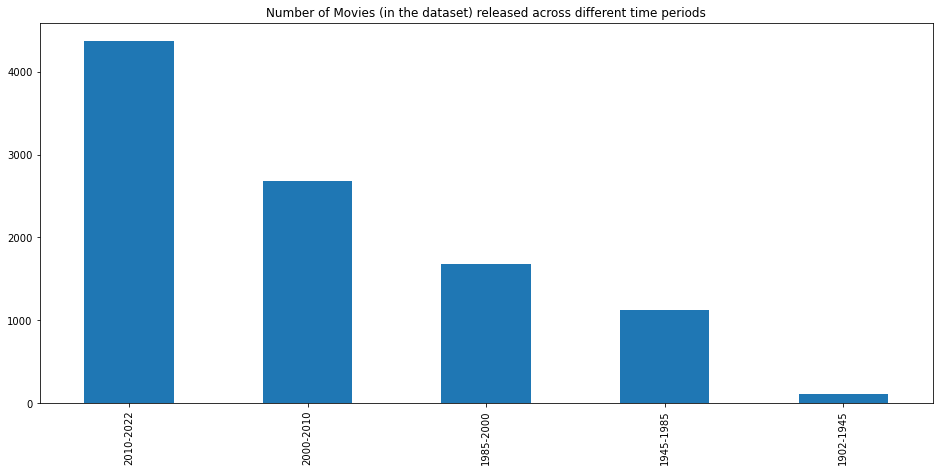

In [12]:
data['timeframes'].value_counts().plot(kind='bar',figsize=(16,7),title='Number of Movies (in the dataset) released across different time periods');

In [13]:
data['timeframes']

0       1985-2000
1       1985-2000
2       1945-1985
3       1985-2000
4       1945-1985
          ...    
9975    2000-2010
9976    2010-2022
9977    2000-2010
9978    2010-2022
9979    2000-2010
Name: timeframes, Length: 9980, dtype: object

In [14]:
data['overview'].isna().sum()

11

In [15]:
data.dropna(inplace=True,axis=0,subset=['overview','timeframes'])

In [16]:
data['overview'].isna().sum()

0

In [17]:
text_overview=[[i] for i in data['overview']]
#text_overview

In [18]:
for news in text_overview[0]:
    print(news)

Framed in the 1940s for the double murder of his wife and her lover, upstanding banker Andy Dufresne begins a new life at the Shawshank prison, where he puts his accounting skills to work for an amoral warden. During his long stretch in prison, Dufresne comes to be admired by the other inmates -- including an older prisoner named Red -- for his integrity and unquenchable sense of hope.


In [19]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
words_remove=['The','the','but','But','When','when','after']
for i in words_remove:
    stop.add(i)
def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for i in range(len(text_overview)):
        for news in text_overview[i]:
            words=[w for w in word_tokenize(news) if (w not in stop)]
        
            words=[lem.lemmatize(w) for w in words if len(w)>2]
        
            corpus.append(words)
    return corpus

corpus=preprocess_news(text_overview)
data['corpus']=corpus
data['corpus2']=corpus

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
#corpus

In [21]:
data['corpus2']

0       [Framed, 1940s, double, murder, wife, lover, u...
1       [Raj, rich, carefree, happy-go-lucky, second, ...
2       [Spanning, year, 1945, 1955, chronicle, fictio...
3       [true, story, businessman, Oskar, Schindler, s...
4       [continuing, saga, Corleone, crime, family, yo...
                              ...                        
9975    [genetically, created, Anaconda, cut, half, re...
9976    [Earth, conquered, robot, another, galaxy, hum...
9977    [Cancer-terminal, tycoon, Peter, Murdoch, secr...
9978    [day, Gerri, Dandridge, sexy, professor, night...
9979    [Three, chimp, sent, space, explore, possibili...
Name: corpus2, Length: 9969, dtype: object

In [22]:
#data['corpus2'][9979]

In [23]:

def strip_corpus(x):
    import re
    x=re.sub('[^a-zA-Z0-9 ]','',str(x))
    return x

data['corpus']=data['corpus'].apply(lambda x: strip_corpus(x))

In [24]:
data['corpus'][9900]

'single mom two boy help take care grandmother mystical power'

In [24]:
!pip install pyLDAvis==3.2.1

In [35]:
!python -m pip install -U gensim

  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.23
    Uninstalling Cython-0.29.23:
      Successfully uninstalled Cython-0.29.23


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
evalml 0.53.1 requires networkx<2.6,>=2.5, but you have networkx 2.6 which is incompatible.


In [31]:
def build_wordcloud(text):
    from wordcloud import WordCloud
    plt.figure(figsize=(16,7))
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    

def build_ldaviz(x,i):
    import gensim
    import pyLDAvis
    #import pyLDAvis.gensim_models
    import pyLDAvis.gensim as gensimvis
    pyLDAvis.enable_notebook()

    dic=gensim.corpora.Dictionary(data[data['original_language']==x]['corpus2'][:i])
    
    bow_corpus = [dic.doc2bow(doc) for doc in data[data['original_language']==x]['corpus2'][:i]]
    lda_model = gensim.models.ldamodel.LdaModel(bow_corpus, 
                                   num_topics=4, 
                                   id2word = dic,
                                   random_state=42,
                                   chunksize=1000,
                                   passes = 50,
                                   iterations=100)
    
    vis =gensimvis.prepare(lda_model, bow_corpus, dic)
    pyLDAvis.save_html(vis, 'lda.html')
    return vis
    

In [26]:
data.sort_values(ascending=False,by='popularity',ignore_index=True,inplace=True)
#data

In [27]:
len(data[data['original_language']=='hindi']['corpus'][:50])

42

In [28]:
str_hi=' '
for i in data[data['original_language']=='hindi']['corpus'][:50]:
    str_hi+=i+' '

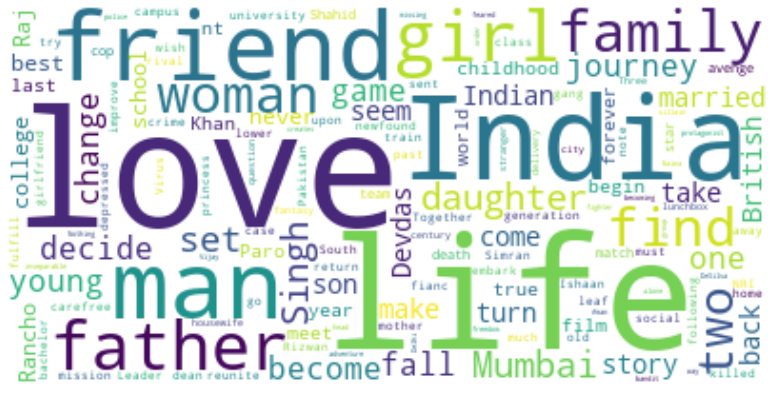

In [29]:
build_wordcloud(str_hi)

In [32]:
build_ldaviz('hindi',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.121552 -0.003355       1        1  31.607663
1     -0.046781 -0.093569       2        1  26.753620
2     -0.040938  0.097158       3        1  25.130577
0     -0.033833 -0.000235       4        1  16.508140, topic_info=        Term      Freq     Total Category  logprob  loglift
499     game  3.000000  3.000000  Default  30.0000  30.0000
639   Shahid  2.000000  2.000000  Default  29.0000  29.0000
85      Khan  2.000000  2.000000  Default  28.0000  28.0000
115  journey  3.000000  3.000000  Default  27.0000  27.0000
513      son  2.000000  2.000000  Default  26.0000  26.0000
..       ...       ...       ...      ...      ...      ...
134    young  0.619105  3.526239   Topic4  -5.5749   0.0616
582   feared  0.619044  1.722691   Topic4  -5.5750   0.7778
56     begin  0.619008  2.263586   Topic4  -5.5750   0.5047
145     else  0.618968  1.671382   Topic4  -5.5751   0.8080
155     much  0.618968  1.671382   Topic4  -5.5751   0.8080

[229 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1         1  0.814541       ...
80        2  0.346860     After
80        3  0.346860     After
80        4  0.346860     After
547       3  0.850096  Although
...     ...       ...       ...
120       3  0.414595     world
134       1  0.283588     young
134       2  0.283588     young
134       3  0.283588     young
134       4  0.283588     young

[270 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

In [38]:
data_hi=data[data['original_language']=='hindi']
data_hi.reset_index(drop=True,inplace=True)
#data_hi

In [43]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

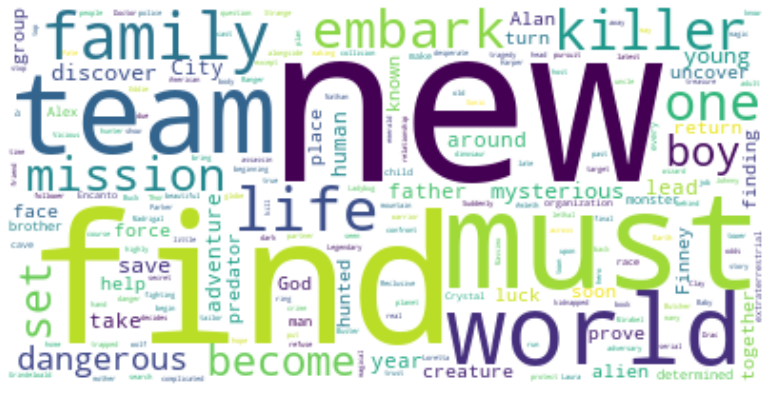

In [44]:
str_en=' '
en_top50=data[data['original_language']=='english'].sort_values(by='popularity',ascending=False,ignore_index=True)[:50]
for i in en_top50['corpus']:
    str_en+=i+' '


%matplotlib inline

build_wordcloud(str_en)


In [41]:
build_ldaviz('english',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.062809  0.083671       1        1  25.998050
3     -0.072059 -0.089261       2        1  25.826798
1      0.089561 -0.032311       3        1  25.775321
2      0.045307  0.037900       4        1  22.399832, topic_info=            Term      Freq     Total Category  logprob  loglift
46        killer  4.000000  4.000000  Default  30.0000  30.0000
543         cave  2.000000  2.000000  Default  29.0000  29.0000
186    dangerous  3.000000  3.000000  Default  28.0000  28.0000
107         find  5.000000  5.000000  Default  27.0000  27.0000
342         Alan  2.000000  2.000000  Default  26.0000  26.0000
..           ...       ...       ...      ...      ...      ...
541       behind  0.690778  1.718306   Topic4  -5.9326   0.5848
377    collision  0.690773  1.712653   Topic4  -5.9326   0.5881
380       course  0.690773  1.712653   Topic4  -5.9326   0.5881
210       Parker  0.690726  1.712655   Topic4  -5.9327   0.5881
232  complicated  0.690678  1.712657   Topic4  -5.9327   0.5880

[211 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
135       3  0.861702  13-year-old
21        1  0.189793        After
21        2  0.379586        After
21        3  0.379586        After
342       2  0.853847         Alan
...     ...       ...          ...
80        3  0.346843         year
80        4  0.346843         year
280       2  0.291089        young
280       3  0.291089        young
280       4  0.291089        young

[240 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

data_en=data[data['original_language']=='english'][:50]
data_en.reset_index(drop=True,inplace=True)


fig = px.scatter(data_en, x=data_en['tsne_coords_x'], y=data_en['tsne_coords_y'],size=data_en['popularity'],
                 color=data_en['timeframes'],hover_name=data_en['title'],log_x=False, size_max=60)
fig.show()

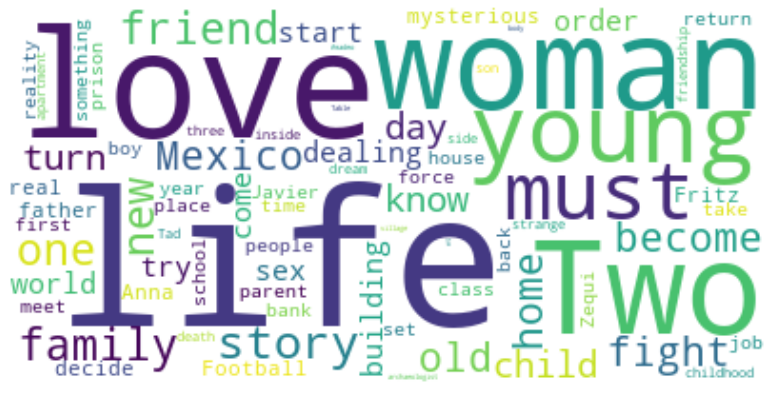

In [45]:
str_es=' '
es_top50=data[data['original_language']=='spanish'].sort_values(by='popularity',ascending=False,ignore_index=True)[:50]
for i in es_top50['corpus']:
    str_es+=i+' '


build_wordcloud(str_es)

In [46]:
build_ldaviz('spanish',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.117319  0.001348       1        1  38.385790
1     -0.044031  0.077290       2        1  21.713692
3     -0.039647 -0.099829       3        1  20.081029
2     -0.033640  0.021192       4        1  19.819490, topic_info=           Term      Freq     Total Category  logprob  loglift
21        child  2.000000  2.000000  Default  30.0000  30.0000
132        love  6.000000  6.000000  Default  29.0000  29.0000
63         time  2.000000  2.000000  Default  28.0000  28.0000
192        bank  2.000000  2.000000  Default  27.0000  27.0000
308         sex  2.000000  2.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
457        lost  0.659569  1.779810   Topic4  -5.8035   0.6258
161       force  0.659565  2.329706   Topic4  -5.8035   0.3566
186  girlfriend  0.659514  1.779804   Topic4  -5.8035   0.6257
288      inmate  0.659512  1.779822   Topic4  -5.8035   0.6257
513   Barcelona  0.659498  1.631486   Topic4  -5.8036   0.7127

[235 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
440       1  1.034799     ...
189       1  0.561129   After
189       2  0.280564   After
189       3  0.280564   After
473       1  0.765410  Amadeo
...     ...       ...     ...
71        3  0.428419    year
142       1  0.377358   young
142       2  0.188679   young
142       3  0.188679   young
142       4  0.188679   young

[301 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

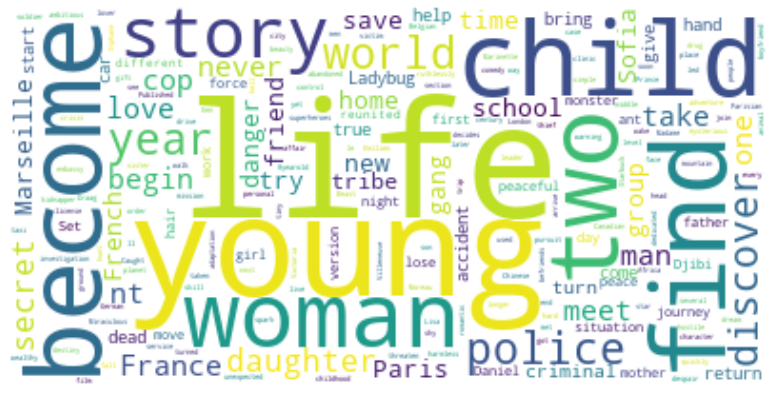

In [47]:
str_fr=' '
fr_top50=data[data['original_language']=='french'].sort_values(by='popularity',ascending=False,ignore_index=True)[:50]
for i in fr_top50['corpus']:
    str_fr+=i+' '


build_wordcloud(str_fr)

In [48]:
build_ldaviz('french',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.073144  0.049702       1        1  31.008682
2     -0.066457 -0.037826       2        1  24.246846
3      0.058192 -0.089948       3        1  22.977343
0      0.081409  0.078072       4        1  21.767129, topic_info=         Term      Freq     Total Category  logprob  loglift
235  daughter  3.000000  3.000000  Default  30.0000  30.0000
224     world  3.000000  3.000000  Default  29.0000  29.0000
504     Sofia  2.000000  2.000000  Default  28.0000  28.0000
28        two  4.000000  4.000000  Default  27.0000  27.0000
669   version  2.000000  2.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
295       one  1.235968  3.367275   Topic4  -5.4593   0.5225
113     woman  1.234967  4.647734   Topic4  -5.4601   0.1994
68       life  1.234054  7.445452   Topic4  -5.4609  -0.2725
200      home  0.687528  2.885511   Topic4  -6.0458   0.0904
582    Africa  0.687401  1.753138   Topic4  -6.0460   0.5885

[208 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
274       1  0.558627    ...
274       2  0.279313    ...
274       4  0.279313    ...
791       4  0.887881    100
553       1  0.830457   1910
...     ...       ...    ...
302       2  0.434696   year
302       3  0.434696   year
161       1  0.662880  young
161       2  0.165720  young
161       4  0.165720  young

[250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

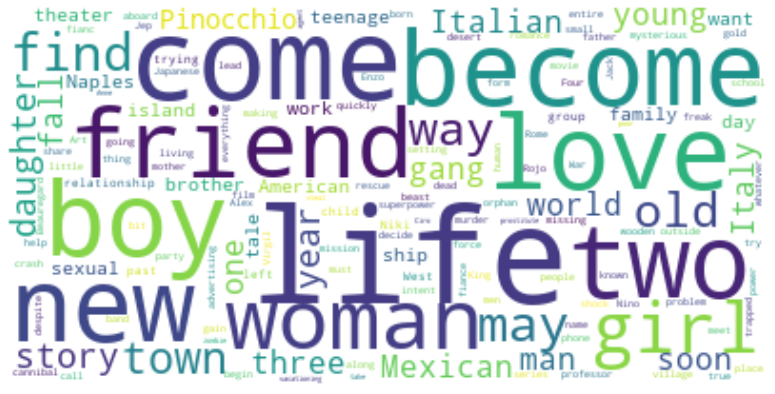

In [49]:
str_it=' '
it_top50=data[data['original_language']=='italian'].sort_values(by='popularity',ascending=False,ignore_index=True)[:50]
for i in it_top50['corpus']:
    str_it+=i+' '


build_wordcloud(str_it)

In [50]:
build_ldaviz('italian',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.105421 -0.010527       1        1  32.207829
1     -0.064253 -0.096045       2        1  26.964894
0     -0.060864  0.088884       3        1  26.876408
3      0.019695  0.017688       4        1  13.950869, topic_info=        Term      Freq     Total Category  logprob  loglift
10       boy  4.000000  4.000000  Default  30.0000  30.0000
330      may  3.000000  3.000000  Default  29.0000  29.0000
63      town  3.000000  3.000000  Default  28.0000  28.0000
398     want  1.000000  1.000000  Default  27.0000  27.0000
30       old  2.000000  2.000000  Default  26.0000  26.0000
..       ...       ...       ...      ...      ...      ...
549  trapped  0.535093  1.571239   Topic4  -5.6578   0.8924
216  theater  0.535089  2.227396   Topic4  -5.6578   0.5435
192   Naples  0.535074  2.191212   Topic4  -5.6579   0.5598
55   becomes  0.535045  2.813222   Topic4  -5.6579   0.3099
387      She  0.535019  2.157038   Topic4  -5.6580   0.5754

[230 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
466       4  1.016564  150-man
313       1  0.555669     1900
418       2  0.874542  20-year
344       1  0.340281    After
344       2  0.340281    After
...     ...       ...      ...
455       3  0.344284     year
161       1  0.381979    young
161       3  0.381979    young
161       4  0.381979    young
804       3  0.578901   zombie

[274 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

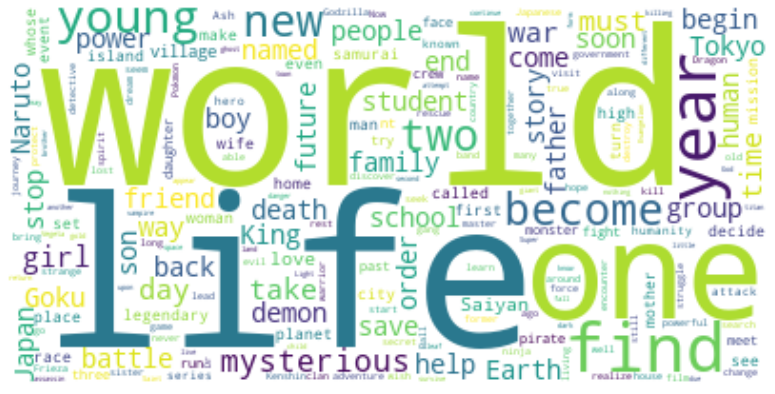

In [51]:
str_ja=' '
for i in data[data['original_language']=='japanese']['corpus']:
    str_ja+=i+' '


build_wordcloud(str_ja)

In [52]:
build_ldaviz('japanese',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.094632  0.068234       1        1  34.822043
1     -0.021848 -0.113388       2        1  27.554440
3      0.109822  0.035663       3        1  26.660985
2      0.006658  0.009491       4        1  10.962531, topic_info=        Term       Freq      Total Category  logprob  loglift
287     Goku  14.000000  14.000000  Default  30.0000  30.0000
182   Naruto  10.000000  10.000000  Default  29.0000  29.0000
508   Minato   3.000000   3.000000  Default  28.0000  28.0000
293   Vegeta   3.000000   3.000000  Default  27.0000  27.0000
230     fire   2.000000   2.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
308  appears   0.536573   2.377652   Topic4  -5.9672   0.7220
18    friend   0.536527   4.309100   Topic4  -5.9673   0.1273
31   student   0.536508   3.667014   Topic4  -5.9674   0.2886
459     love   0.536436   2.321889   Topic4  -5.9675   0.7455
543     fall   0.536368   1.679902   Topic4  -5.9676   1.0690

[234 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
381       2  0.526688    're
213       1  0.883401    ...
1083      2  0.526688    100
124       1  0.439451  After
124       2  0.146484  After
...     ...       ...    ...
284       2  0.412688   year
284       3  0.137563   year
123       1  0.309243  young
123       2  0.309243  young
123       4  0.309243  young

[303 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

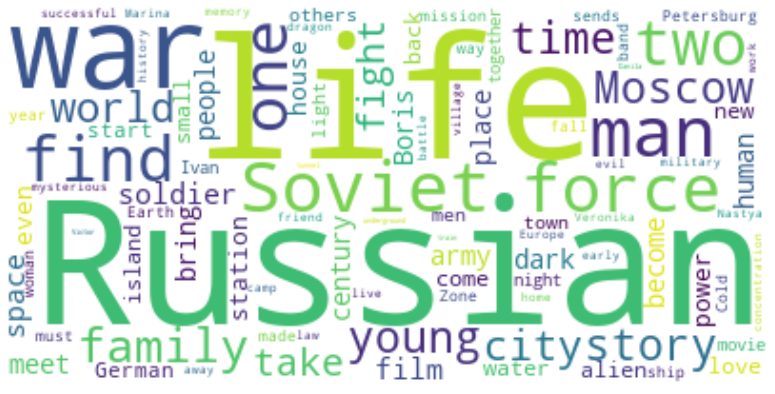

In [53]:
str_ru=' '
for i in data[data['original_language']=='russian']['corpus']:
    str_ru+=i+' '


build_wordcloud(str_ru)

In [54]:
build_ldaviz('russian',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.099580  0.046107       1        1  44.548354
0     -0.097629  0.052340       2        1  23.954431
1     -0.004944 -0.102455       3        1  19.294924
2      0.002993  0.004008       4        1  12.202291, topic_info=        Term      Freq     Total Category  logprob  loglift
135   Soviet  6.000000  6.000000  Default  30.0000  30.0000
635    Boris  3.000000  3.000000  Default  29.0000  29.0000
111    force  5.000000  5.000000  Default  28.0000  28.0000
887   Danila  1.000000  1.000000  Default  27.0000  27.0000
889   Victor  1.000000  1.000000  Default  26.0000  26.0000
..       ...       ...       ...      ...      ...      ...
768    three  0.523408  1.693422   Topic4  -5.8450   0.9294
280   German  0.523396  2.937641   Topic4  -5.8450   0.3785
327   behind  0.523375  1.693445   Topic4  -5.8451   0.9293
898       go  0.523373  1.693448   Topic4  -5.8451   0.9293
900  instead  0.523373  1.693448   Topic4  -5.8451   0.9293

[237 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
322       1  0.608872    ...
322       2  0.304436    ...
706       3  0.616441   1943
743       1  1.005584   1965
132       1  0.543034  After
...     ...       ...    ...
98        2  0.439552   year
98        4  0.439552   year
131       1  0.401692  young
131       2  0.401692  young
131       3  0.200846  young

[289 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

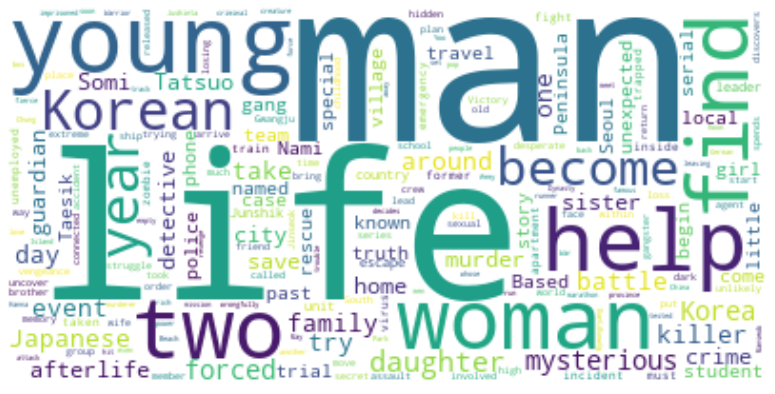

In [55]:
str_ko=' '
ko_top50=data[data['original_language']=='korean'].sort_values(by='popularity',ascending=False,ignore_index=True)[:50]
for i in ko_top50['corpus']:
    str_ko+=i+' '


build_wordcloud(str_ko)

In [56]:
build_ldaviz('korean',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.115161  0.034957       1        1  30.084734
1     -0.018686 -0.108836       2        1  29.302276
0     -0.085875  0.070093       3        1  25.908949
3     -0.010600  0.003787       4        1  14.704041, topic_info=          Term      Freq     Total Category  logprob  loglift
226       Somi  2.000000  2.000000  Default  30.0000  30.0000
69        find  5.000000  5.000000  Default  29.0000  29.0000
124     around  3.000000  3.000000  Default  28.0000  28.0000
721     Tatsuo  3.000000  3.000000  Default  27.0000  27.0000
590     become  3.000000  3.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
148       move  0.583237  1.675332   Topic4  -5.6714   0.8619
65        city  0.583166  2.935913   Topic4  -5.6715   0.3007
286      South  0.583150  1.675363   Topic4  -5.6715   0.8617
285      Seoul  0.583051  2.276798   Topic4  -5.6717   0.5548
67   desperate  0.583014  1.675408   Topic4  -5.6718   0.8614

[225 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
223       3  0.844968    'the
224       3  0.444210     ...
224       4  0.444210     ...
283       4  0.953924    1997
398       1  0.241623   After
...     ...       ...     ...
222       1  0.314295   young
222       2  0.314295   young
222       3  0.157147   young
222       4  0.314295   young
39        2  0.544512  zombie

[271 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

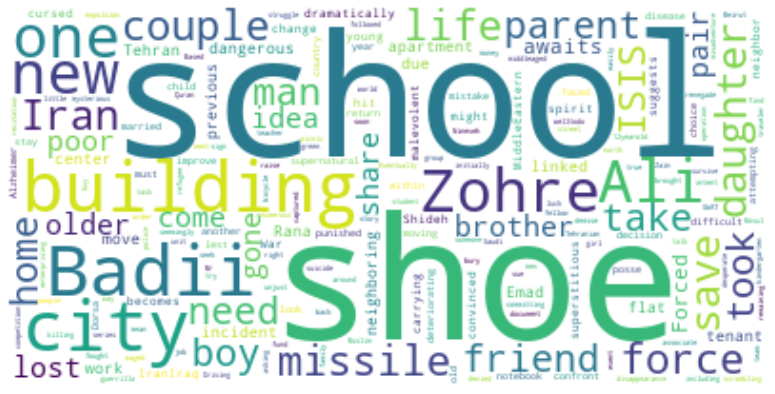

In [57]:
str_pe=' '
for i in data[data['original_language']=='persian']['corpus']:
    str_pe+=i+' '
    
str_ar=' '
for i in data[data['original_language']=='arabic']['corpus']:
    str_ar+=i+' '

str_middleeast=str_pe+str_ar

build_wordcloud(str_middleeast)

In [58]:
build_ldaviz('persian',50)

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
3     -0.105771  0.0       1        1  71.143913
0      0.113581  0.0       2        1  26.804256
2     -0.003905  0.0       3        1   1.025916
1     -0.003905  0.0       4        1   1.025914, topic_info=          Term      Freq     Total Category  logprob  loglift
96       Badii  1.000000  1.000000  Default  30.0000  30.0000
15        shoe  2.000000  2.000000  Default  29.0000  29.0000
21    building  2.000000  2.000000  Default  28.0000  28.0000
117        man  1.000000  1.000000  Default  27.0000  27.0000
85      friend  1.000000  1.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
67   Alzheimer  0.011455  1.086524   Topic4  -4.9835   0.0272
69     another  0.011455  1.086524   Topic4  -4.9835   0.0272
70       child  0.011455  1.086524   Topic4  -4.9835   0.0272
71     country  0.011455  1.086524   Topic4  -4.9835   0.0272
72    decision  0.011455  1.086524   Topic4  -4.9835   0.0272

[216 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
39        1  0.920328      After
0         1  1.094317        Ali
67        1  0.920366  Alzheimer
96        2  1.002903      Badii
40        1  0.920328      Dorsa
...     ...       ...        ...
144       1  0.920409    teacher
94        1  0.920390       took
145       1  0.920409   traveler
66        1  0.920328     within
95        1  0.920390       year

[97 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

In [59]:
build_ldaviz('arabic',50)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.128706 -0.006581       1        1  45.215884
2      0.073314 -0.092818       2        1  27.597148
0      0.059367  0.100295       3        1  26.130525
3     -0.003975 -0.000897       4        1   1.056443, topic_info=            Term      Freq     Total Category  logprob  loglift
24          city  1.000000  1.000000  Default  30.0000  30.0000
19          ISIS  1.000000  1.000000  Default  29.0000  29.0000
31          home  1.000000  1.000000  Default  28.0000  28.0000
11         right  0.000000  0.000000  Default  27.0000  27.0000
1         Beirut  0.000000  0.000000  Default  26.0000  26.0000
..           ...       ...       ...      ...      ...      ...
47         Saudi  0.011052  0.968894   Topic4  -4.1744   0.0767
49           buy  0.011052  0.968894   Topic4  -4.1744   0.0767
52  enterprising  0.011052  0.968894   Topic4  -4.1744   0.0767
54          girl  0.011052  0.968894   Topic4  -4.1744   0.0767
55         green  0.011052  0.968894   Topic4  -4.1744   0.0767

[155 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         3  1.046770  12-year-old
18        1  0.919751        Based
1         3  1.046770       Beirut
19        1  0.575375         ISIS
20        1  0.919751        Mosul
...     ...       ...          ...
44        1  0.919751         unit
16        3  1.046770       unjust
45        1  0.919751        waged
64        2  1.032104          way
17        3  1.046770        world

[65 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

In [61]:
stored_movie_alllang=[str_hi,str_en,str_es,str_fr,str_it,str_ko,str_ja,str_ru,str_pe,str_ar]

In [62]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-distilroberta-v1')


In [63]:
emb_hi=model.encode(str_hi)
emb_en=model.encode(str_en)
emb_es=model.encode(str_es)
emb_fr=model.encode(str_fr)
emb_it=model.encode(str_it)
emb_ko=model.encode(str_ko)
emb_ja=model.encode(str_ja)
emb_ru=model.encode(str_ru)
emb_pe=model.encode(str_pe)
emb_ar=model.encode(str_ar)



embeddings=[emb_hi,emb_en,emb_es,emb_fr,emb_it,emb_ko,emb_ja,emb_ru,emb_pe,emb_ar]

In [64]:
from sklearn.metrics.pairwise import cosine_similarity as cs

In [65]:
cs([emb_hi],[emb_en])

array([[0.6390718]], dtype=float32)

In [66]:
scores=[]
for i in range(len(embeddings)):
    for j in range(len(embeddings)):
        s=cs([embeddings[i]],[embeddings[j]])
        scores.append(s)

In [67]:
len(scores)

100

In [68]:
scores_arr=np.array(scores).reshape(-10,10)
scores_arr

array([[1.        , 0.6390718 , 0.7815536 , 0.82303417, 0.80340624,
        0.80153763, 0.6578844 , 0.6464155 , 0.6094659 , 0.19634387],
       [0.6390718 , 1.0000002 , 0.6807716 , 0.74994636, 0.75749683,
        0.8053731 , 0.74957883, 0.71122456, 0.43648782, 0.13812205],
       [0.7815536 , 0.6807716 , 1.0000002 , 0.86842334, 0.8773853 ,
        0.772079  , 0.65887046, 0.60411245, 0.53441   , 0.16101721],
       [0.82303417, 0.74994636, 0.86842334, 0.9999999 , 0.88822556,
        0.8518838 , 0.6546128 , 0.73595035, 0.5809854 , 0.20567106],
       [0.80340624, 0.75749683, 0.8773853 , 0.88822556, 1.        ,
        0.83054703, 0.69308513, 0.7046212 , 0.49118847, 0.07243682],
       [0.80153763, 0.8053731 , 0.772079  , 0.8518838 , 0.83054703,
        1.        , 0.7365475 , 0.72521824, 0.58530736, 0.13857666],
       [0.6578844 , 0.74957883, 0.65887046, 0.6546128 , 0.69308513,
        0.7365475 , 0.9999999 , 0.7003844 , 0.47201598, 0.14081614],
       [0.6464155 , 0.71122456, 0.6041124

In [69]:
mean_similarity_arr=[]
for i in range(len(scores_arr)):
    mean_similarity=1-np.mean(scores_arr[i])
    mean_similarity_arr.append(mean_similarity)
    

In [70]:
mean_similarity_arr

[0.3041287064552307,
 0.33319270610809326,
 0.30613768100738525,
 0.264126718044281,
 0.28816068172454834,
 0.2752929925918579,
 0.35362040996551514,
 0.35844194889068604,
 0.44061946868896484,
 0.7368881106376648]

In [71]:
ylab=['hindi','english','spanish','french','italian','korean','japanese','russian','persian','arabic']
xlab=ylab

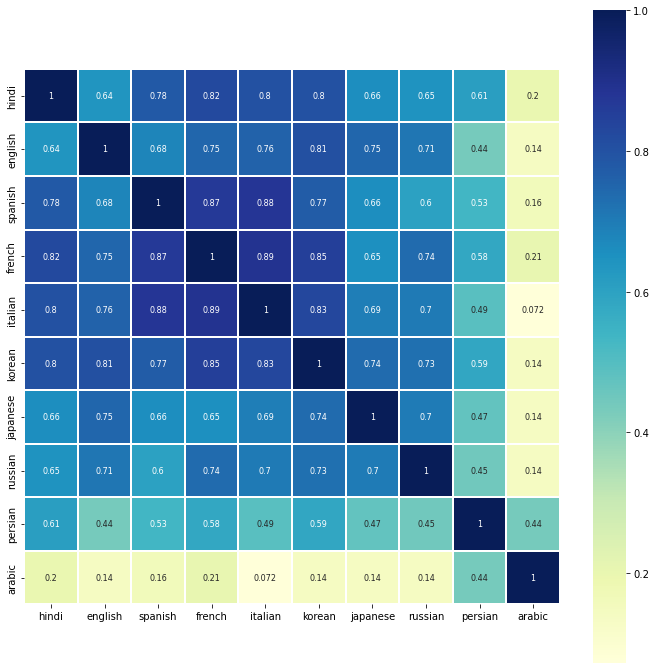

<Figure size 432x288 with 0 Axes>

In [124]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(scores_arr, xticklabels=xlab,yticklabels=ylab,square=True, cmap="YlGnBu", linewidths=0.1,annot=True, annot_kws={"fontsize":8})
plt.show()
plt.savefig('similarity.png')

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer()
docs = tfidf.fit_transform(data['corpus'])

In [127]:
from sklearn.decomposition import PCA
pca=PCA(2)
x_pca=pca.fit_transform(docs.toarray())

In [82]:
x_pca

array([[-0.10328283, -0.10791889],
       [-0.1062711 , -0.11967775],
       [-0.10560261, -0.11681701],
       ...,
       [-0.10193802, -0.11007925],
       [-0.10906109, -0.12056187],
       [-0.09289064, -0.10019957]])

9969

In [130]:
import plotly.express as px

fig = px.scatter(x_pca, x=x_pca[:,0], y=x_pca[:,1],color=data['timeframes'],
                 hover_name=data['title'],title='Visualization of top movies across the world, across different timeframes',log_x=False, size_max=100)
fig.show()



In [100]:
import chart_studio

username='odetothecode'
api_key='g9qGi5QONnwvqoeXH8hg'

chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

import chart_studio.plotly as py
import chart_studio.tools as tls

In [110]:
x_pca[0]

array([-0.05805572, -0.00647145])

In [111]:
data['pca_coords']=list(x_pca)

In [131]:
data_hi=data[data['original_language']=='hindi']
data_hi.reset_index(drop=True,inplace=True)

tfidf=TfidfVectorizer()
docs = tfidf.fit_transform(data_hi['corpus'])

from sklearn.decomposition import PCA
pca=PCA(2)
x_pca=pca.fit_transform(docs.toarray())

In [133]:
fig = px.scatter(x_pca, x=x_pca[:,0], y=x_pca[:,1],color=data_hi['timeframes'], title='Visualization of top movies across India, across different timeframes'
                 ,hover_name=data_hi['title'], log_x=False, size_max=100)
fig.show()

In [122]:
py.plot(fig,'Movies_across_timeframes',auto_open=False)

'https://plotly.com/~odetothecode/2/'